In [2]:
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from typing import List, Tuple, Dict, Set, Optional
import nltk
nltk.download('stopwords')

from snippets import unpack_file, load_text_data, MyCallback, plot_graphs

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/magdalena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
FILE = "tweet-sentiment-extraction.zip"
DIR = "tweets"

TRAIN_FILE = DIR + "/train.csv"
TEST_FILE = DIR + "/test.csv"

unpack_file(FILE, DIR)

Files unzipped to /tweets


In [4]:
SENTIMENT_TO_LABEL = {
        "positive": 2,
        "neutral": 1,
        "negative": 0,
    }
LABEL_TO_SENTIMENT = {label: sentiment for sentiment, label in SENTIMENT_TO_LABEL.items()}

train_texts, train_sentiments = load_text_data(TRAIN_FILE, 2, 3, remove_stopwords=True)
train_labels = [SENTIMENT_TO_LABEL[sentiment] for sentiment in train_sentiments]
train_labels = tf.keras.utils.to_categorical(train_labels, dtype=int)    

test_texts, test_sentiments = load_text_data(TEST_FILE, 1, 2)
test_labels = [SENTIMENT_TO_LABEL[sentiment] for sentiment in test_sentiments]
test_labels = tf.keras.utils.to_categorical(test_labels, dtype=int)    

In [5]:
EMBEDDING_DIM = 16
MAX_WORDS = 1000
MAX_SEQUENCE_LEN = 50

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<oov>")
tokenizer.fit_on_texts(train_texts)

sequences_train = tokenizer.texts_to_sequences(train_texts)
padded_train = pad_sequences(sequences_train, padding = "post", maxlen = MAX_SEQUENCE_LEN)

sequences_test = tokenizer.texts_to_sequences(test_texts)
padded_test = pad_sequences(sequences_test, padding = "post", maxlen = MAX_SEQUENCE_LEN)

In [6]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(len(tokenizer.word_index)+1, EMBEDDING_DIM, input_length = MAX_SEQUENCE_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = "relu"),
    tf.keras.layers.Dense(3, activation = "softmax")
])
model.summary()

my_callback = MyCallback()
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), loss="categorical_crossentropy", metrics=["acc"])
history = model.fit(padded_train, 
                    train_labels, 
                    epochs=1, 
                    verbose=1, 
                    callbacks=[my_callback], 
                    validation_data=(padded_test, test_labels)
                   )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            458096    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 75        
Total params: 458,579
Trainable params: 458,579
Non-trainable params: 0
_________________________________________________________________
Train on 27486 samples, validate on 3535 samples
27486/27486 [==============================] - 8s 302us/sample - loss: 0.9427 - acc: 0.5549 - val_loss: 2.5014 - val_acc: 0.4124


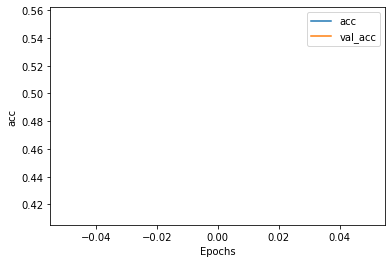

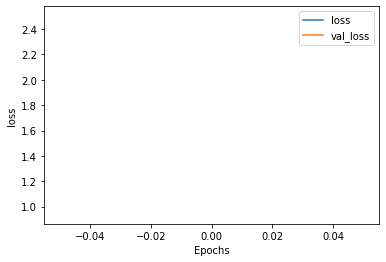

In [7]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [7]:
GLOVE_FILE = "glove.6B.zip"
def loadGloveEmbeddings(file: str) -> Dict:
    """ Load GloVe word embeddings from a file
        Args:
            file:                               file with GloVe embeddings. File format as in https://nlp.stanford.edu/projects/glove/
        
        Returns:
            word2vec:                           dictionnary mapping word to empedding vector
    """

    FOLDER = "embeddings"
    unpack_file(file, FOLDER)

    word2vec = {}
    f = open(FOLDER + "/glove.6B.100d.txt")
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        word2vec[word] = coefs

    return word2vec


def createEmbeddingLayer(word2index: dict, word2vec: dict) -> tf.keras.layers.Embedding:
    """ Set up pretrained Embedding layer
        Credits to: https://keras.io/examples/pretrained_word_embeddings/
        Args:
            word2index:                         dictionnary mapping words to indices
            word2vec:                           dictionnary mapping words to embedding vectors
        Returns:
            embedding_layer                     layer with pretrained GloVe word embeddings
    """

    num_words = min(MAX_WORDS, len(word2index)) + 1
    emb_dim = word2vec["cucumber"].shape[0]
    emb_matrix = np.zeros((num_words, emb_dim))

    for word, index in word2index.items():
        if index > MAX_WORDS:
            break
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector

    embedding_layer = tf.keras.layers.Embedding(
        num_words, emb_dim, input_length=MAX_SEQUENCE_LEN, trainable=False
    )  # Do not update word embeddings
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

In [8]:
word2vec = loadGloveEmbeddings(GLOVE_FILE)

Files unzipped to /embeddings


In [9]:
embedding_layer = createEmbeddingLayer(tokenizer.word_index, word2vec)

In [10]:
tf.keras.backend.clear_session()

# Embedding layer
sentence_indices = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LEN,), dtype="int32")
embedding_layer = createEmbeddingLayer(tokenizer.word_index, word2vec)
embeddings = embedding_layer(sentence_indices)

# Dense layers
x = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
x = tf.keras.layers.Dense(24, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.models.Model(inputs=sentence_indices, outputs=x)

model.summary()
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001), loss="categorical_crossentropy", metrics=["acc"])
history = model.fit(
    padded_train,train_labels, 
    epochs=50,
    verbose=1,
    callbacks=[my_callback],
    validation_data=(padded_test, test_labels)
)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 100)           100100    
_________________________________________________________________
global_average_pooling1d (Gl (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                2424      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 75        
Total params: 102,599
Trainable params: 2,499
Non-trainable params: 100,100
_________________________________________________________________
Train on 27486 samples, validate on 3535 samples
Epoch 1/50
27486/27486 [==============================] - 2s 75us/sa

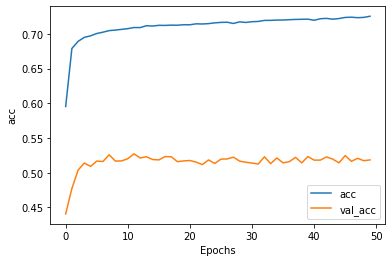

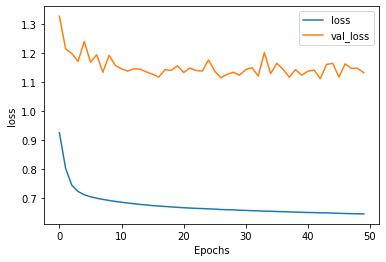

In [11]:
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [12]:
# Out of sample prediction

def evaluate_sentence(model: tf.keras.models.Model, sentence: str) -> int:
    
    sentence = [[word for word in sentence.split() if word not in STOPWORDS]]
    sequence = tokenizer.texts_to_sequences(sentence)
    padded = pad_sequences(sequence, padding = "post", maxlen = MAX_SEQUENCE_LEN)
    
    label = np.argmax(model.predict(padded))

    return LABEL_TO_SENTIMENT[label]

In [13]:
sentence = "I am going to the shop"
evaluate_sentence(model, sentence)

NameError: name 'STOPWORDS' is not defined